# Most Ideal comparison (i think theoretically) when comparing to c2c12

In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as pd
import numpy as np
from adjustText import adjust_text
import matplotlib.pylab as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv("data_adj/fixed_counts_matrix.tsv", sep="\t")
#here is where you filter which samples you want
data = data.filter(items=['gene_id',
                'LB_10.5_NA_1', 'LB_10.5_NA_2','LB_11.5_NA_1', 'LB_11.5_NA_2',
                'G_4_F_1', 'G_4_F_2','G_4_M_1', 'G_4_M_2',
                'SM_0_NA_1', 'SM_0_NA_2',
                'MB_1', 'MB_2','MB_3', 'MB_4','MB_5',
                'MT_1', 'MT_2', 'MT_3', 'MT_4', 'MT_5'])
data = data.set_index(data["gene_id"])
data = data.drop('gene_id', axis=1)

In [3]:
data.head()

,LB_10.5_NA_1,LB_10.5_NA_2,LB_11.5_NA_1,LB_11.5_NA_2,G_4_F_1,G_4_F_2,G_4_M_1,G_4_M_2,SM_0_NA_1,SM_0_NA_2,MB_1,MB_2,MB_3,MB_4,MB_5,MT_1,MT_2,MT_3,MT_4,MT_5
gene_id,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000099183.1,0,0,0,0,2,4,1,8,1,4,12,4,0,0,1,12,19,6,2,4
ENSMUSG00000065559.1,96,350,1561,1909,720323,517475,652657,101,298316,447669,70786,15451,27143,24389,27329,2584038,4111798,1074677,1300194,1256891
ENSMUSG00000065480.1,4,25,92,83,444,373,427,10,2556,4440,2433,306,334,359,1088,103180,104254,26475,26033,21244
ENSMUSG00000065405.3,18023,20008,13458,15665,26029,16861,16800,17258,17696,20188,223146,132440,125913,135138,120392,46398,64996,27729,28878,25335
ENSMUSG00000065567.1,125,57,111,71,213,240,186,1986,51,87,5289,1440,2074,1710,2018,535,812,517,529,416


In [4]:
metadata = pd.read_csv("data_adj/metadata.tsv", sep="\t",
                      usecols=["File.accession", "Biosample.term.name", "Age", "Sample"])

In [5]:
# Filter metadata DataFrame based on matching samples in merged_df
metadata_filtered = metadata[metadata['Sample'].isin(data.columns)].copy()

# Sort filtered_metadata based on the order of columns in merged_df
metadata_filtered['Sample'] = pd.Categorical(metadata_filtered['Sample'], categories=data.columns)
metadata_filtered.sort_values('Sample', inplace=True)

In [6]:
filtering = {'Biosample.term.name': ['limb', 'skeletal muscle tissue'],#whatever you need from the biosample names
             'Age': ["ED_10.5","PND_0"]}
group = 'Age' # change to the group you're interested in making the comparison in

In [7]:
metadata_selected = metadata_filtered.copy(deep=True)

In [8]:
for col in filtering.keys():
    metadata_selected = metadata_selected[metadata_selected[col].isin(filtering[col])]

In [9]:
metadata_selected

,File.accession,Biosample.term.name,Age,Sample
33,ENCFF398EBM,limb,ED_10.5,LB_10.5_NA_1
34,ENCFF065GME,limb,ED_10.5,LB_10.5_NA_2
47,ENCFF431VHL,skeletal muscle tissue,PND_0,SM_0_NA_1
49,ENCFF430EME,skeletal muscle tissue,PND_0,SM_0_NA_2


In [10]:
metadata_selected.index = metadata_selected['Sample']
data_selected = data.loc[:, metadata_selected['Sample']]

In [11]:
data_selected

,LB_10.5_NA_1,LB_10.5_NA_2,SM_0_NA_1,SM_0_NA_2
gene_id,,,,
ENSMUSG00000099183.1,0,0,1,4
ENSMUSG00000065559.1,96,350,298316,447669
ENSMUSG00000065480.1,4,25,2556,4440
ENSMUSG00000065405.3,18023,20008,17696,20188
ENSMUSG00000065567.1,125,57,51,87
...,...,...,...,...
ENSMUSG00000099172.1,0,0,0,0
ENSMUSG00000093219.1,2,0,0,1
ENSMUSG00000065602.1,210,251,5658,5973


In [12]:
metadata_selected

,File.accession,Biosample.term.name,Age,Sample
Sample,,,,
LB_10.5_NA_1,ENCFF398EBM,limb,ED_10.5,LB_10.5_NA_1
LB_10.5_NA_2,ENCFF065GME,limb,ED_10.5,LB_10.5_NA_2
SM_0_NA_1,ENCFF431VHL,skeletal muscle tissue,PND_0,SM_0_NA_1
SM_0_NA_2,ENCFF430EME,skeletal muscle tissue,PND_0,SM_0_NA_2


In [13]:
dds = DeseqDataSet(
    counts=data_selected.T,
    clinical=metadata_selected,
    design_factors=group,
    refit_cooks=True)

dds.deseq2()
stat_res = DeseqStats(dds, 
                      contrast=[group] + filtering[group])
stat_res.summary()

Fitting size factors...
... done in 0.00 seconds.



/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Fitting dispersions...
... done in 5.12 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 3.61 seconds.

Fitting LFCs...
... done in 1.55 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.97 seconds.

Log2 fold change & Wald test p-value: Age ED_10.5 vs PND_0


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000099183.1,1.365541,-4.132403,3.153848,-1.310274,1.901033e-01,NaN
ENSMUSG00000065559.1,216089.078125,-11.076686,0.587608,-18.850456,2.913192e-79,1.194409e-77
ENSMUSG00000065480.1,2012.313477,-8.258882,1.167066,-7.076618,1.477154e-12,8.116733e-12
ENSMUSG00000065405.3,19390.013672,-0.444857,0.374448,-1.188033,2.348203e-01,3.226239e-01
ENSMUSG00000065567.1,77.627342,-0.059238,0.509246,-0.116326,9.073943e-01,9.354762e-01
...,...,...,...,...,...,...
ENSMUSG00000099172.1,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000093219.1,0.653674,0.500976,3.316191,0.151070,8.799206e-01,NaN
ENSMUSG00000065602.1,3550.146729,-5.112180,0.393834,-12.980547,1.577502e-38,2.627528e-37


In [14]:
l2fc_cutoff = 2 # Log 2 fold change; usually 0.5 - 2
pval_cutoff = 0.05 # 0.01 is even better than 0.05

In [15]:
annot = pd.read_csv("data_adj/mirna_id_to_name.tsv", sep="\t")
annot.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
df = stat_res.results_df.copy(deep=True)

In [17]:
# Find the machine-specific lowest non-zero value
lowest_nonzero_value = df['padj'][df['padj'] > 0].min()

# Replace 0 with the lowest non-zero value
df['padj'] = np.where(df['padj'] == 0, lowest_nonzero_value, df['padj'])

df = df.dropna()
df = df.merge(annot, left_index=True, right_on='gene_id')
df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,gene_name
0,216089.078125,-11.076686,0.587608,-18.850456,2.913192e-79,1.194409e-77,ENSMUSG00000065559.1,Mir206
1,2012.313477,-8.258882,1.167066,-7.076618,1.477154e-12,8.116733e-12,ENSMUSG00000065480.1,Mir133b
818,19390.013672,-0.444857,0.374448,-1.188033,2.348203e-01,3.226239e-01,ENSMUSG00000065405.3,Mir30a
2,77.627342,-0.059238,0.509246,-0.116326,9.073943e-01,9.354762e-01,ENSMUSG00000065567.1,Mir30c-2
4,8.627024,-0.872885,1.066560,-0.818411,4.131227e-01,5.085321e-01,ENSMUSG00000092852.1,Mir5103
...,...,...,...,...,...,...,...,...
909,34.737404,-0.631187,0.583602,-1.081537,2.794583e-01,3.770918e-01,ENSMUSG00000093102.1,Mir3475
805,24119.359375,0.378077,0.361462,1.045966,2.955765e-01,3.939943e-01,ENSMUSG00000076011.1,Mir652
810,6.916032,1.051279,1.060200,0.991586,3.213997e-01,4.168030e-01,ENSMUSG00000080331.1,Mir1298
814,3550.146729,-5.112180,0.393834,-12.980547,1.577502e-38,2.627528e-37,ENSMUSG00000065602.1,Mirlet7f-2


In [18]:
# Calculate -log10(padj)
df['nlog10padj'] = -np.log10(df['padj'])

# Add labels to DE column based on our cutoffs above
df['DE'] = "No"
df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange > l2fc_cutoff)] = "Up"
df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange < -l2fc_cutoff)] = "Down"

/tmp/ipykernel_1996015/1959988433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange > l2fc_cutoff)] = "Up"
/tmp/ipykernel_1996015/1959988433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange < -l2fc_cutoff)] = "Down"


In [20]:
#use later for venn diagram (down = 72hr, up = 0hr)
degs = df.filter(items=['gene_name', 'DE'])
degs.to_csv("data_adj/degs_sm.tsv", sep="\t")

/tmp/ipykernel_1764437/2083456970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.label[df.DE == "No"] = ""
/tmp/ipykernel_1764437/2083456970.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down.sort_values(["padj"], inplace=True)
/tmp/ipykernel_1764437/2083456970.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up.sort_values(["padj"], inplace=True)


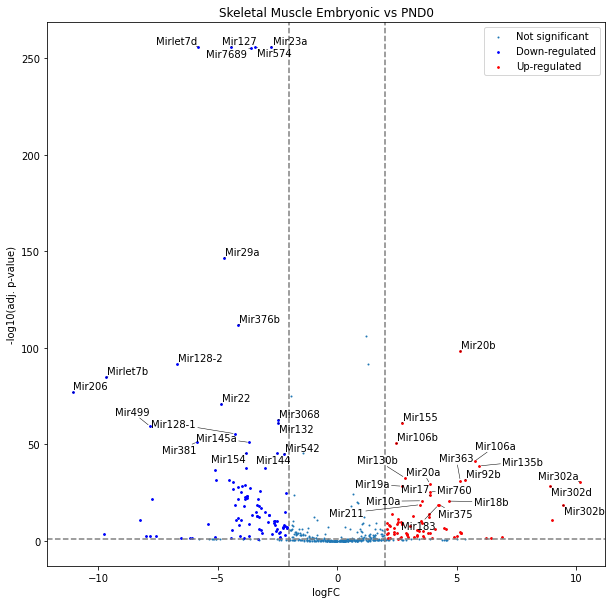

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

In [20]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

df['label'] = df.gene_name
df.label[df.DE == "No"] = ""

# Create the figure
fig, ax = plt.subplots()

# Set the figure size
fig.set_size_inches(10, 10)

# Plot whole df first (with small size dots)
ax.scatter(x=df['log2FoldChange'], y=df['nlog10padj'], s=1, label="Not significant")

# Highlight up- or down-regulated genes
down = df[df.DE == "Down"]
down.sort_values(["padj"], inplace=True)
up = df[df.DE == "Up"]
up.sort_values(["padj"], inplace=True)

# Overlay up- and down-regulated gene dfs with larger label and specific color
ax.scatter(x=down['log2FoldChange'], y=down['nlog10padj'], s=3, label="Down-regulated", color="blue")
ax.scatter(x=up['log2FoldChange'], y=up['nlog10padj'], s=3, label="Up-regulated", color="red")

# Display names of top 20 up- or down-regulated genes
n_genes = 20
texts = []
for i in range(min(n_genes, up.shape[0])):
    texts.append(ax.text(x=up.iloc[i, 1],
                         y=up.iloc[i, 8],
                         s=up.iloc[i, 7]))
for i in range(min(n_genes, down.shape[0])):
    texts.append(ax.text(x=down.iloc[i, 1],
                         y=down.iloc[i, 8],
                         s=down.iloc[i, 7]))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Draw lines indicating lfc and padj cutoffs
ax.set_xlabel("logFC")
ax.set_ylabel("-log10(adj. p-value)")
ax.axvline(l2fc_cutoff, color="grey", linestyle="--")
ax.axvline(-l2fc_cutoff, color="grey", linestyle="--")
ax.axhline(-np.log10(pval_cutoff), color="grey", linestyle="--")

# Draw legend
ax.legend()

# Add a title to the plot
#ax.set_title("C2C12 0hr vs 72hr")
ax.set_title("Skeletal Muscle Embryonic vs PND0")

# Save the plot as a high-resolution PNG with specific width and height
#output_file = "plots/volcano_c2c12.png"
output_file = "plots/volcano_skeletal.png"
plt.savefig(output_file, dpi=300)

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>